# Comparison among GD, Newton method and Richardson (Appoximate Newton) 

In [ ]:
import numpy as np 
import torch
from torch.nn import Module
from torch.autograd import grad
import torchvision.datasets as datasets
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
np.random.seed(100)
torch.manual_seed(100)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def hessian(grads, model):
    """
    Order: W first, then b
    """
    size = grads[0].shape[1] + 1  # +1 is for the bias
    hess = torch.zeros(size, size).to(device)
    i = 0
    for grad in grads[0].flatten():
        W_second = torch.autograd.grad(grad, model.parameters(), retain_graph=True)
        hess[i] = torch.cat([W_second[0], W_second[1].view(1, 1)], 1)
        i += 1
    b_second = torch.autograd.grad(grads[1], model.parameters(), retain_graph=True)
    hess[i] = torch.cat([b_second[0], b_second[1].view(1, 1)], 1)
    i += 1
    return hess
    


In [ ]:
def newton_direction(grads, model):
    """
    Order: W first, then b
    """
    grads_as_vector = torch.cat([-grads[0].data.clone().detach(), -grads[1].clone().view(1, 1)], 1)
    hess = hessian(grads, model).to(device)
    inverse_hess = torch.inverse(hess).to(device)
    direction = torch.matmul(grads_as_vector, inverse_hess)
    weights_direction = direction[0, 0:-1].view(grads[0].shape).to(device)
    bias_direction = direction[0, -1].view(grads[1].shape).to(device)
    return [weights_direction, bias_direction]


In [ ]:
def richardson_iter(grads, model, tol=1e-6):
    def hessian_max_min_eig(grads, model):
        hess = hessian(grads, model).to(device)
        eigvalues = torch.eig(hess)[0]
        real_eigvalues = [real for real, img in eigvalues if torch.abs(img) < 1e-6]
        return max(real_eigvalues), min(real_eigvalues)
    newton_direction = [torch.zeros_like(param.data) for param in model.parameters()]
    eigmax, eigmin = hessian_max_min_eig(grads, model)
    alpha = 2 / (eigmax + eigmin)
    num_iters = int(torch.ceil(((eigmax + eigmin) / (2 * eigmin)) * np.log(1/tol)))
    # print("alpha:", alpha)
    for it in range(1, num_iters + 1):
        model.zero_grad()
        Hv = torch.autograd.grad(grads, 
                                 model.parameters(), 
                                 grad_outputs=newton_direction, 
                                 create_graph=False, 
                                 retain_graph=True)
        for dt, hv, grad in zip(newton_direction, Hv, grads):
            dt.data = dt.data - alpha * hv - alpha * grad.data
    return newton_direction

In [ ]:
def descent_direction(loss, model, mode="sgd"):
    """
    mode: eigther "sgd", "newton", or "richardson"
    """
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    mode = mode.lower()
    if mode not in ["sgd", "newton", "richardson"]:
        raise Exception("Undefined mode of direction. Must be either sgd or newton")
    if mode == "sgd":
        return [-grad.data.to(device) for grad in grads]
    elif mode == "newton":
        return newton_direction(grads, model)
    else:
        return richardson_iter(grads, model, tol=1e-6)

In [ ]:
def plot(comparison, dataset="", filename=None):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(comparison["sgd"]["training_loss"], label="SGD")
    plt.plot(comparison["newton"]["training_loss"], label="True Newton")
    plt.plot(comparison["richardson"]["training_loss"], label="Richardson")
    plt.legend()
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Training Loss", size=15)
    plt.subplot(133)
    plt.bar(["SGD"], comparison["sgd"]["training_time"])
    plt.bar(["Newton"], comparison["newton"]["training_time"])
    plt.bar(["Richardson"], comparison["richardson"]["training_time"])

    plt.ylabel("Training time (s)", size=15)
    plt.subplot(132)
    plt.plot(comparison["sgd"]["test_loss"], label="SGD")
    plt.plot(comparison["newton"]["test_loss"], label="True Newton")
    plt.plot(comparison["richardson"]["test_loss"], label="Richardson")
    plt.legend()
    plt.xlabel("Epoch", size=15)
    plt.ylabel("Test Loss", size=15)
    plt.suptitle("Convex Task: {} (d=100)".format(dataset), fontsize=16, y=0.0)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
def print_conf_matrix(y_test, y_pred):
  conf_mat = confusion_matrix(y_test, y_pred)
  print(confusion_matrix)
  sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)



def multi_acc(y_pred, y_test):
  
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    correct_pred.cpu().detach().numpy()



    for i in range(len(correct_pred)):
      sum = correct_pred[i][1000]
    # print(sum)
    # print(correct_pred)
    # # print(type(correct_pred))
    #print(correct_pred.size())
    # print(correct_pred.sum())
    #print(correct_pred.sum())

    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [ ]:
from sklearn.metrics import confusion_matrix
# from ignite.metrics import ClassificationReport
accuracy = []
inputs_acc = []
targets_acc = []
outputs_acc = []
prediction = []
def compare_models(model="linear_reg", modes=["sgd", "newton", "richardson"], 
                   lr=[0.03, 1., 1.], lamb=0.01, epochs=300, 
                   full_batch=True, verbose=False):
    if model == "linear_reg":
        loss_fn = nn.MSELoss(reduction="mean")
    else:
        loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
        
    data = {}
    for i, mode in enumerate(modes):
        data[mode] = {"training_loss": [], "training_time": 0., "test_loss": []}
        LinearRegression = nn.Sequential(nn.Linear(15,1)).to(device)
        for param in LinearRegression.parameters():
            if len(param.shape) >= 2:
                nn.init.xavier_uniform_(param)
        start = time.time()
        #####################################

        ####################################
        for epoch in range(1, epochs+1):
            LinearRegression.zero_grad()
            
            if full_batch:
                X_tr, y_tr = X_train, y_train
            else:
                X_tr, y_tr = get_next_batch(train=True)
            
            test_loss = loss_fn(LinearRegression(X_test.to(device)), y_test.to(device))
            data[mode]["test_loss"].append(test_loss.item())

            loss = loss_fn(LinearRegression(X_tr.to(device)), y_tr.to(device))



            for param in LinearRegression.parameters():
                loss += (lamb / 2) * torch.sum(param * param)

            ###################################
            # out, target = LinearRegression(X_test.to(device)), y_test.to(device)
            # # out = LinearRegression(data)
            # # target,out = LinearRegression(X_test.to(device)), y_test.to(device)
            # acc = multi_acc(out, target)
            # accu = acc.item()
            # accuracy.append(accu)
            # label.append(y_test)
            prediction.append(torch.sigmoid(LinearRegression(X_test.to(device))))
            ##################################
                
            directions = descent_direction(loss, LinearRegression, "newton")
            for param, direction in zip(LinearRegression.parameters(), directions):
                param.data.add_(lr[i] * direction)
            if verbose and epoch % 20 == 0:
              print("Epoch {:3d}: loss = {:.3f}".format(epoch, loss.item()))
            data[mode]["training_loss"].append(loss.item())
            
        data[mode]["training_time"] = time.time() - start

    return data

# Logistic Regression

In [ ]:
import pandas as pd
data1 = pd.read_csv('Classification_data.csv')

In [ ]:
data1.head()

,Unnamed: 0,Country,Fulfill Via,Vendor INCO Term,Product Group,Sub Classification,Vendor,Molecule/Test Type,Brand,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Pack Price,Manufacturing Site,Weight (Kilograms),Freight Cost (USD),islate
0,0,0.214286,0.0,0.714286,0.75,0.4,0.761905,0.638554,0.688889,0.9375,0.029029,0.000054,0.023200,0.869048,0.000015,0.002691,0.0
1,1,0.952381,0.0,0.714286,0.50,1.0,0.158730,0.867470,0.311111,0.5000,0.239239,0.002997,0.004960,0.119048,0.000418,0.015607,0.0
2,2,0.214286,0.0,0.857143,0.75,0.4,0.142857,0.325301,0.222222,0.9375,0.099099,0.001497,0.064000,0.047619,0.000199,0.005707,0.0
3,3,0.952381,0.0,0.714286,0.50,0.2,0.888889,0.662651,0.311111,0.6250,0.059059,0.095757,0.003192,0.904762,0.002164,0.055260,0.0
4,4,0.952381,0.0,0.714286,0.50,0.2,0.158730,0.963855,0.311111,0.0000,0.059059,0.113997,0.002560,0.119048,0.008853,0.156910,0.0


In [ ]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
data1['islate'].value_counts()

0.0    3730
1.0     367
Name: islate, dtype: int64

In [ ]:
y = data1.pop('islate')
X = data1

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42,sampling_strategy='auto')
X, y = sm.fit_resample(X, y)

## Generate the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).view(-1, 1).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).view(-1, 1).to(device)
train_set =  TensorDataset(X_train, y_train)
test_test = TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_test, batch_size=1000, shuffle=False)
iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)

def get_next_batch(train=True):
    iter_loader = iter_train_loader if train else iter_test_loader
    data_loader = train_loader if train else test_loader
    try:
        # Samples a new batch for persionalizing
        (X, y) = next(iter_loader)
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        iter_loader = iter(data_loader)
        (X, y) = next(iter_loader)
    return (X, y)

## Compare the models

In [ ]:
comparison = compare_models(model="logistic_reg")

In [ ]:
newton_test_loss = comparison['newton']['test_loss']
sgd_test_loss = comparison['sgd']['test_loss']
richardson_test_loss = comparison['richardson']['test_loss']
newton_training_loss = comparison['newton']['training_loss']
sgd_training_loss = comparison['sgd']['training_loss']
richardson_training_loss = comparison['richardson']['training_loss']
newton_training_time = comparison['newton']['training_time']
sgd_training_time = comparison['sgd']['training_time']
richardson_training_time = comparison['richardson']['training_time']

In [ ]:
data_info_singlebatch = pd.DataFrame({'newton_test_loss':newton_test_loss, 
                          'sgd_test_loss':sgd_test_loss,
                          'richardson_test_loss':richardson_test_loss,
                          'newton_training_loss':newton_training_loss,
                          'sgd_training_loss':sgd_training_loss,
                          'richardson_training_loss':richardson_training_loss,
                          'newton_training_time':newton_training_time,
                          'sgd_training_time':sgd_training_time,
                          'richardson_training_time':richardson_training_time})

In [ ]:
data_info_singlebatch.to_csv('data_info_singlebatch.csv')

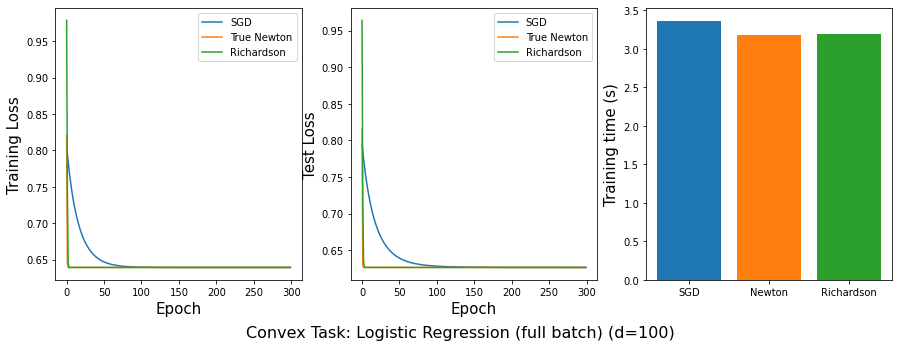

In [ ]:
plot(comparison, dataset="Logistic Regression (full batch)", filename="logistic_regression_full_batch.pdf")

In [ ]:
comparison = compare_models(model="logistic_reg", full_batch=False,
                            lr=[0.01, 0.1, 0.03])

In [ ]:
comparison['newton'].keys()

dict_keys(['training_loss', 'training_time', 'test_loss'])

In [ ]:
newton_test_loss = comparison['newton']['test_loss']

In [ ]:
sgd_test_loss = comparison['sgd']['test_loss']

In [ ]:
richardson_test_loss = comparison['richardson']['test_loss']

In [ ]:
newton_training_loss = comparison['newton']['training_loss']
sgd_training_loss = comparison['sgd']['training_loss']
richardson_training_loss = comparison['richardson']['training_loss']

In [ ]:
newton_training_time = comparison['newton']['training_time']
sgd_training_time = comparison['sgd']['training_time']
richardson_training_time = comparison['richardson']['training_time']

In [ ]:
data_info = pd.DataFrame({'newton_test_loss':newton_test_loss, 
                          'sgd_test_loss':sgd_test_loss,
                          'richardson_test_loss':richardson_test_loss,
                          'newton_training_loss':newton_training_loss,
                          'sgd_training_loss':sgd_training_loss,
                          'richardson_training_loss':richardson_training_loss,
                          'newton_training_time':newton_training_time,
                          'sgd_training_time':sgd_training_time,
                          'richardson_training_time':richardson_training_time})

In [ ]:
data_info.to_csv('data_info.csv')

In [ ]:
comparison

{'newton': {'test_loss': [0.8196010589599609,
   0.7816022634506226,
   0.7538750171661377,
   0.732624888420105,
   0.7156916856765747,
   0.70005202293396,
   0.6874437928199768,
   0.6775516271591187,
   0.6696615815162659,
   0.6627078652381897,
   0.656977653503418,
   0.6529873013496399,
   0.6497119665145874,
   0.6459272503852844,
   0.642983615398407,
   0.6407490372657776,
   0.6389228105545044,
   0.6371769905090332,
   0.6355796456336975,
   0.6347655057907104,
   0.6336577534675598,
   0.6329361796379089,
   0.6322332620620728,
   0.6315883994102478,
   0.6309371590614319,
   0.6303691864013672,
   0.6301483511924744,
   0.629803478717804,
   0.6293797492980957,
   0.6290517449378967,
   0.6288042068481445,
   0.6284048557281494,
   0.628031849861145,
   0.6279404163360596,
   0.6280072927474976,
   0.6280238032341003,
   0.6276988983154297,
   0.6274113655090332,
   0.6273264288902283,
   0.6274055242538452,
   0.6272559762001038,
   0.6273873448371887,
   0.6270350217819

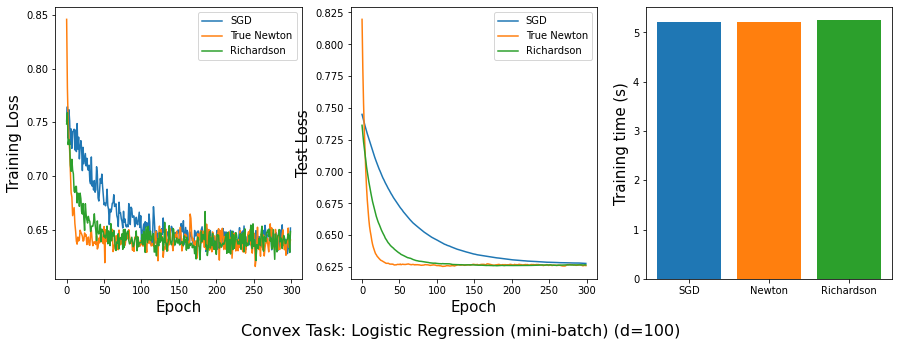

In [ ]:
plot(comparison, dataset="Logistic Regression (mini-batch)", filename="logistic_regression_mini_batch.pdf")

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
